In [25]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
df = pd.read_csv('rollingsales_brooklyn.xls_prepped_bare.csv')

In [27]:
df.reset_index(drop=True)

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
0,1,11228.0,1300000,2020-04-28
1,1,11228.0,75000,2020-11-30
2,1,11214.0,830000,2020-06-26
3,1,11214.0,1188000,2020-07-20
4,1,11214.0,990000,2021-02-22
...,...,...,...,...
11619,4,11237.0,470000,2020-12-01
11620,4,11237.0,15000,2021-02-18
11621,4,11237.0,600000,2021-02-12
11622,4,11237.0,900000,2020-11-19


In [28]:
df['SALE DATE']= pd.to_datetime(df['SALE DATE'])
df=df.sort_values(by='SALE DATE')

In [29]:
type(df['SALE DATE'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [30]:
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])

In [31]:
df_price_date = df_price_date.set_index('SALE DATE')

In [32]:
# df_price_date.index.unique

In [33]:
#group by day
df_price_date = df_price_date.resample('D').mean()

In [34]:
df_price_date['SALE PRICE']=df_price_date['SALE PRICE'].fillna(0)

In [35]:
df_price_date.loc[(df_price_date!=0).any(1)]

,SALE PRICE
SALE DATE,
2020-04-01,3.977437e+06
2020-04-02,8.185471e+05
2020-04-03,1.815030e+06
2020-04-04,2.333627e+05
2020-04-06,8.709561e+05
...,...
2021-03-25,1.216184e+06
2021-03-26,1.064060e+06
2021-03-29,1.002984e+06


In [36]:
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=12)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [37]:
register_matplotlib_converters()

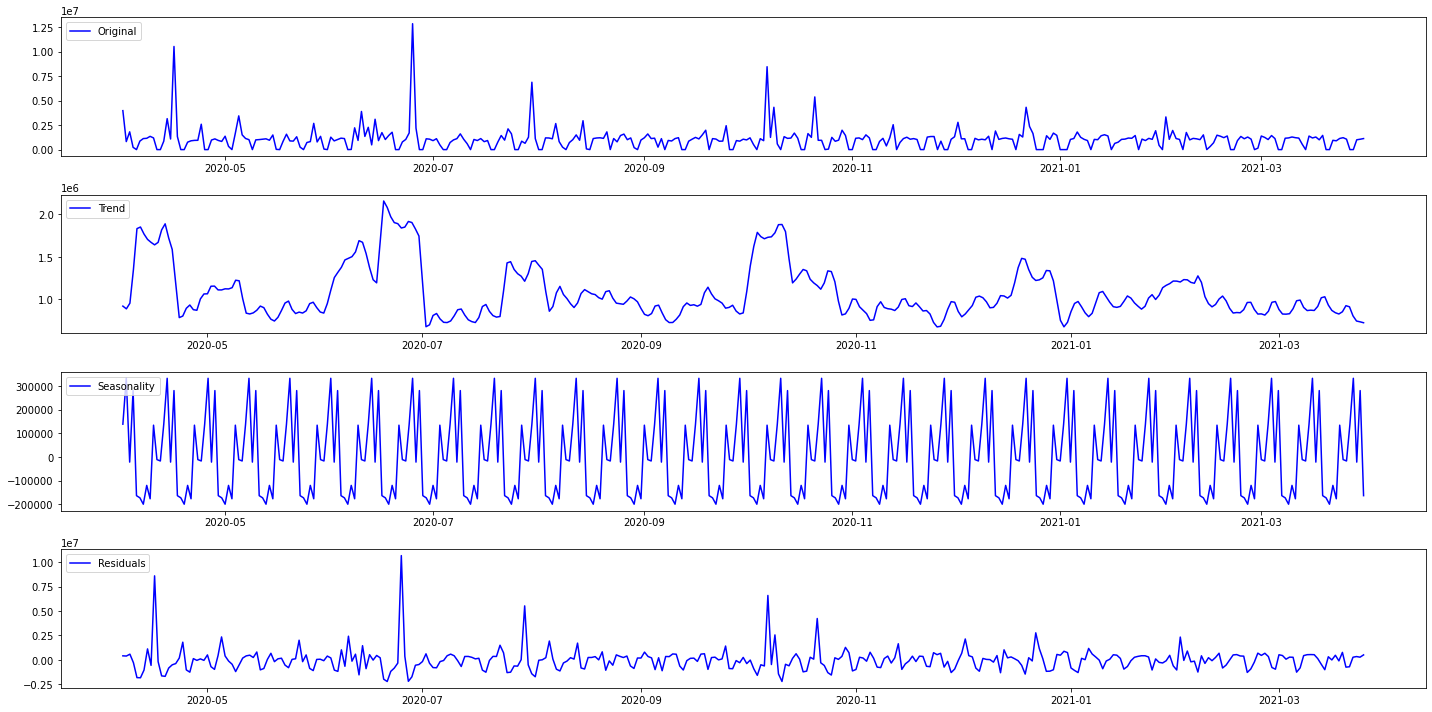

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [39]:
# df_price_date['roll_avg'] = df_price_date['SALE PRICE'].rolling(window=5).mean()

In [40]:
# df_price_date

In [41]:
# plt.figure(figsize=(20, 10))
# plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
# plt.scatter(df_price_date.index[4:365], df_price_date['roll_avg'][4:365], s=20);

In [42]:
# lr = LinearRegression()
# lr.fit(df_price_date[['roll_avg']][4:], df_price_date['SALE PRICE'][4:])

In [43]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_price_date.index[:265], df_price_date['SALE PRICE'][:265], label='Data')
# plt.plot(df_price_date.index[4:265], lr.predict(df_price_date[['roll_avg']][4:265]),
#          label='Predicted')
# plt.legend();

In [44]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-4.665875408357549, 9.749187516484523e-05, 15, 349, {'1%': -3.449226932880019, '5%': -2.869857365438656, '10%': -2.571201085130664}, 10619.45547609437)

Test Statistic                  -4.665875
p-value                          0.000097
#Lags Used                      15.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


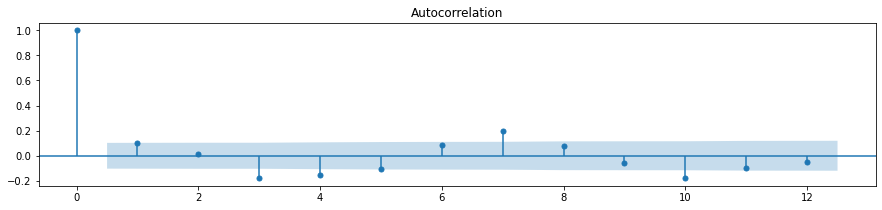

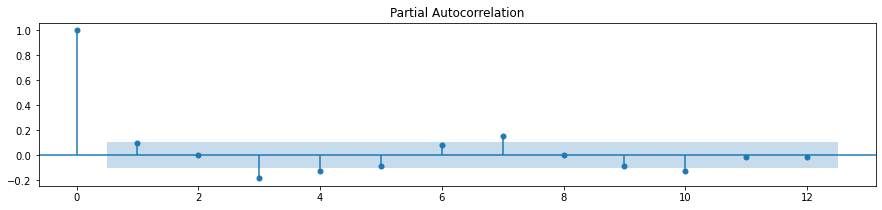

In [45]:
rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date, lags=12, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date, lags=12, alpha=0.05);

In [46]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
#about 2/3 of the way between 25 and 50, 2/3 of 25 is roughly 17. Ill say 25 + 17 = 42
p = 2

 # q = lagged forecast errors - PACF
    
q = 2


# Fitting ARMA model and summary
ar = ARMA(df_price_date,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  365
Model:                     ARMA(2, 2)   Log Likelihood               -5627.557
Method:                       css-mle   S.D. of innovations        1201372.590
Date:                Sat, 12 Jun 2021   AIC                          11267.113
Time:                        21:44:22   BIC                          11290.512
Sample:                    04-01-2020   HQIC                         11276.412
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.07e+06   7.11e+04     15.038      0.000     9.3e+05    1.21e+06
ar.L1.SALE PRICE    -0.6447      0.482     -1.337      0.181      -1.590       0.301
ar.L2.SALE PRICE    -0.1796      0.244     -0.737      0.461      -0.657       0.298
ma.L1.SALE PRICE     0.7524      0.469      1.603      0.109      -0.167       1.672
ma.L2.SALE PRICE     0.3119      0.237      1.315      0.189      -0.153       0.777
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7944           -1.5320j            2.3594           -0.3875
AR.2           -1.7944           +1.5320j            2.3594            0.3875
MA.1           -1.2061           -1.3234j            1.7905           -0.3676
MA.2           -1.2061           +1.3234j            1.7905            0.3676
-----------------------------------------------------------------------------
"""

In [47]:
r2_score(df_price_date, ar.predict())

0.019129429743995674

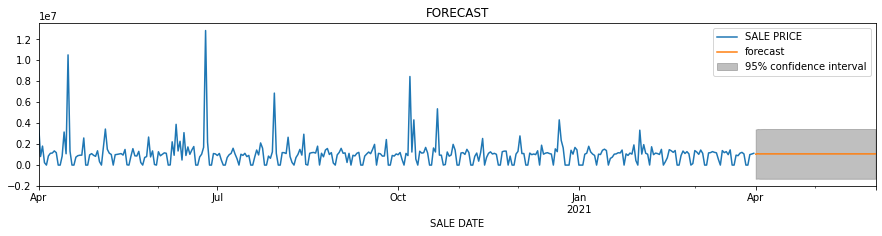

In [48]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date.plot(ax=ax, title='FORECAST')
fig = ar.plot_predict('2021-04-01', '2021-06-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()